In [1]:
import pandas as pd
import os
from typing import List, Optional, Dict
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# !pip3 install pandas
#!pip3 install pyarrow
# !pip3 install pandas
#!pip3 install fastparquet



### Data Fetch

In [3]:
def fetch_nsduh_data(year: int) -> Optional[pd.DataFrame]:
    """
    Fetches NSDUH data for a specified year from a remote source.

    Args:
        year (int): The year for which to fetch data.

    Returns:
        Optional[pd.DataFrame]: A pandas DataFrame with the data, or None if fetching failed.
    """
    url_placeholder = "https://www.datafiles.samhsa.gov/sites/default/files/field-uploads-protected/studies/NSDUH-{year}/NSDUH-{year}-datasets/NSDUH-{year}-DS0001/NSDUH-{year}-DS0001-bundles-with-study-info/NSDUH-{year}-DS0001-bndl-data-tsv.zip"
    
    try:
        url = url_placeholder.format(year=year)
        df = pd.read_csv(url, compression='zip', sep='\t', low_memory=False)
        return df
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")
        return None

In [4]:
def check_parquet_exists(years: List[int], output_dir: str) -> Dict[int, bool]:
    """
    Checks if Parquet files for the specified years already exist in the output directory.

    Args:
        years (List[int]): A list of years to check.
        output_dir (str): The directory where Parquet files are saved.

    Returns:
        Dict[int, bool]: A dictionary with years as keys and boolean values indicating 
                         whether the Parquet file for that year exists.
    """
    existence_check = {}
    
    for year in years:
        year_path = os.path.join(output_dir, f'year={year}')
        existence_check[year] = os.path.exists(year_path)
    
    return existence_check

In [5]:
def write_parquet(df: pd.DataFrame, year: int, output_dir: str, overwrite: bool = False) -> None:
    """
    Writes a DataFrame to Parquet format, partitioned by year.

    Args:
        df (pd.DataFrame): The DataFrame to write.
        year (int): The year of the data.
        output_dir (str): The directory where Parquet files will be saved.
        overwrite (bool): If True, overwrite existing files. If False, skip existing files.
    """
    try:
        year_dir = os.path.join(output_dir, f'year={year}')
        if overwrite and os.path.exists(year_dir):
            shutil.rmtree(year_dir)  # Remove existing directory to start fresh

        df['year'] = year  # Add the year column for partitioning
        # Write data to Parquet format with partitioning
        df.to_parquet(output_dir, partition_cols=['year'], index=False)
        
        print(f"Data for year {year} successfully saved to Parquet format in {output_dir}")
    except Exception as e:
        print(f"Error saving data to Parquet for year {year}: {e}")

In [6]:
def data_fetch(years_to_fetch: List[int], output_dir: str, overwrite: bool = False) -> None:
    """
    Fetches NSDUH data for specified years and saves it to Parquet format, one year at a time.

    Args:
        years_to_fetch (List[int]): A list of years for which to fetch data.
        output_dir (str): The directory where Parquet files will be saved.
        overwrite (bool): If True, overwrite existing files. If False, skip existing files.
    """
    try:
        for year in years_to_fetch:
            if not overwrite and os.path.exists(os.path.join(output_dir, f'year={year}')):
                print(f"Data for year {year} already exists. Skipping.")
                continue

            df = fetch_nsduh_data(year)
            if df is not None:
                print(f"Successfully fetched data for year: {year}")
                write_parquet(df, year, output_dir, overwrite)
                del df  # Remove the DataFrame from memory
                gc.collect()  # Force garbage collection

        print("All requested years processed.")
    except Exception as e:
        print(f"An unexpected error occurred in the data_fetch function: {e}")

In [7]:
def read_parquet(input_dir: str, years: Optional[List[int]] = None) -> pd.DataFrame:
    """
    Reads Parquet files for specified years from the input directory and combines them into a single DataFrame.
    Args:
        input_dir (str): The directory where Parquet files are stored.
        years (Optional[List[int]]): A list of years to read. If None, read all available years.
    Returns:
        pd.DataFrame: A pandas DataFrame with the data for the specified years.
    """
    data_frames = []
    available_years = [int(d.split('=')[1]) for d in os.listdir(input_dir) if d.startswith('year=')]
    years_to_read = years if years is not None else available_years

    for year in years_to_read:
        year_path = os.path.join(input_dir, f'year={year}')
        if os.path.exists(year_path):
            df = pd.read_parquet(year_path)

            # Convert data types to reduce memory usage
            for col in df.select_dtypes(include=['float64']).columns:
                df[col] = df[col].astype('float32')

            data_frames.append(df)
        else:
            print(f"Warning: No data found for year {year}")

    if data_frames:
        combined_df = pd.concat(data_frames, ignore_index=True)
        return combined_df
    else:
        print("Warning: No data was loaded.")
        return pd.DataFrame()


In [8]:
if __name__ == "__main__":
    # Example usage
    years = [2015, 2016, 2017, 2018, 2019] 
    output_directory = "../data/DS/NSDUH"
    
    # Fetch and save data
    data_fetch(years, output_directory, overwrite=False)

    # Read saved data (if needed)
    # Note: This part is optional and can be removed if you don't need to read the data immediately after saving
    for year in years:
        df = read_parquet(output_directory, [year])
        if year in df:
            print(f"Data for year {year}:")
            print(df[year].head())
        #del df
        gc.collect()

Data for year 2015 already exists. Skipping.
Data for year 2016 already exists. Skipping.
Data for year 2017 already exists. Skipping.
Data for year 2018 already exists. Skipping.
Data for year 2019 already exists. Skipping.
All requested years processed.


### Name : Rama Rao Vydadi
### Person Number : 50604256

### Hypothesis 1: Individuals with lower income are more likely to experience mental health issues or Unemployment is a significant predictor of mental health disorders
### How does socioeconomic status (income, education, employment status) influence the likelihood of experiencing mental health disorders?
### •	Understanding the correlation between socio-economic factors and mental health can help identify vulnerable populations and provide support for economically weak population.
### Hypothesis 2: Frequent marijuana use correlates with higher prevalence of depression.
### What role does marijuana use play in the aggravation of mental health disorders?
### •	Understanding the relationship between marijuana use and mental health will help us to answer sensitive questions like should marijuana be banned all over the world
### Hypothesis 3: Unregulated use of hallucinogens can cause mental health problems like anxiety and depression.
### What role does hallucinogens play in mental health disorders?
### •	Understanding the relationship between use of various hallucinogens and mental health will suggest us to regulate the supply of medical hallucinogens


#We will first perform the basic data cleaning steps and then perform EDA 

In [9]:
df.head()

,QUESTID2,FILEDATE,CIGEVER,CIGOFRSM,CIGWILYR,CIGTRY,CIGYFU,CIGMFU,CIGREC,CIG30USE,...,POVERTY3,TOOLONG,TROUBUND,PDEN10,COUTYP4,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP
0,43295143,10/09/2020,1,99,99,13,9999,99,4,93,...,3.0,2,2,2,2,2,2,6613.865723,40004,2
1,65095143,10/09/2020,2,99,99,991,9991,91,91,91,...,3.0,2,2,2,2,2,2,6321.580566,40003,1
2,49405143,10/09/2020,1,99,99,22,9999,99,4,93,...,3.0,2,2,2,2,2,2,5045.607422,40008,1
3,51015143,10/09/2020,2,99,99,991,9991,91,91,91,...,1.0,2,2,2,2,2,2,2419.558838,40031,1
4,31825143,10/09/2020,2,99,99,991,9991,91,91,91,...,3.0,2,2,2,2,2,2,575.225464,40010,2


In [10]:
df.shape

(56136, 2741)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56136 entries, 0 to 56135
Columns: 2741 entries, QUESTID2 to VEREP
dtypes: float32(407), int64(2332), object(2)
memory usage: 1.1+ GB


In [12]:
df.describe()

,QUESTID2,CIGEVER,CIGOFRSM,CIGWILYR,CIGTRY,CIGYFU,CIGMFU,CIGREC,CIG30USE,CG30EST,...,POVERTY3,TOOLONG,TROUBUND,PDEN10,COUTYP4,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP
count,5.613600e+04,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,...,55609.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000,56136.000000
mean,5.434607e+07,1.542700,78.595554,78.605458,550.575816,9840.048846,92.951600,50.651080,80.111248,92.784915,...,2.427179,2.173650,2.199854,1.662997,1.747827,1.982827,1.982560,4902.758301,40025.570899,1.504400
std,2.563167e+07,0.498178,39.056828,39.037478,485.236660,1099.156156,12.225758,43.980321,26.734751,4.208800,...,0.776759,4.797938,4.794185,0.627146,0.762371,0.129915,0.130904,5952.114746,14.388113,0.499985
min,1.000945e+07,1.000000,1.000000,1.000000,1.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.581148,40001.000000,1.000000
25%,3.198245e+07,1.000000,99.000000,99.000000,16.000000,9991.000000,91.000000,3.000000,91.000000,91.000000,...,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1262.476593,40013.000000,1.000000
50%,5.403939e+07,2.000000,99.000000,99.000000,991.000000,9991.000000,91.000000,91.000000,91.000000,91.000000,...,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2855.374878,40025.000000,2.000000
75%,7.625105e+07,2.000000,99.000000,99.000000,991.000000,9999.000000,99.000000,91.000000,93.000000,93.000000,...,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,6076.500732,40038.000000,2.000000
max,9.999669e+07,2.000000,99.000000,99.000000,997.000000,9999.000000,99.000000,91.000000,98.000000,99.000000,...,3.000000,98.000000,98.000000,3.000000,3.000000,2.000000,2.000000,77284.484375,40050.000000,2.000000


In [13]:
df.columns

Index(['QUESTID2', 'FILEDATE', 'CIGEVER', 'CIGOFRSM', 'CIGWILYR', 'CIGTRY',
       'CIGYFU', 'CIGMFU', 'CIGREC', 'CIG30USE',
       ...
       'POVERTY3', 'TOOLONG', 'TROUBUND', 'PDEN10', 'COUTYP4', 'MAIIN102',
       'AIIND102', 'ANALWT_C', 'VESTR', 'VEREP'],
      dtype='object', length=2741)

In [14]:
filtered_df=df.copy()

Selecting only required columns from the entire dataset (This is an iterative step after performing EDA)

In [15]:
desired_columns = [
    'QUESTID2', 'IRWRKSTAT', 'IREDUHIGHST2', 'INCOME', 'IRSEX', 'MJEVER',
    'PNRANYLIF', 'COUTYP4', 'MEDMJPA2', 'DSTCHR30', 'ADDPREV', 'LSD', 'PCP', 'PEYOTE', 'MESC', 'PSILCY', 'ECSTMOLLY', 'KETMINESK', 'DMTAMTFXY', 'SALVIADIV', 'HALLUCOTH'
]

filtered_df = df[desired_columns]



In [16]:
#We have various hallucinogens in our dataset we can standardize the mapping and remove the unwanted data 
#like "Dont know", "Refused" etc with nan values 

In [17]:
lsd_mapping = {
    1: 'Yes',  # "Yes"
    2: 'No',   # "No"
    3: 'Yes',  # "Yes logically assigned"
    91: 'No',  # "Never used hallucinogens"
    94: np.nan,  # "Don't know" replaced with NaN
    97: np.nan   # "Refused" replaced with NaN
}

# Apply the mapping to the 'LSD' column
filtered_df['LSD'] = filtered_df['LSD'].map(lsd_mapping)

C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\1422645912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LSD'] = filtered_df['LSD'].map(lsd_mapping)


In [18]:
#we can create similar mapping for all hallucinogens

In [19]:
substance_mapping = {
    1: 'Yes',  # "Yes"
    2: 'No',   # "No"
    91: 'No',  # "Never used hallucinogens"
    94: np.nan,  # "Don't know" replaced with NaN
    97: np.nan   # "Refused" replaced with NaN
}

substance_columns = ['PCP', 'PEYOTE', 'MESC', 'PSILCY', 'ECSTMOLLY', 'KETMINESK', 'DMTAMTFXY', 'SALVIADIV', 'HALLUCOTH']

for col in substance_columns:
    filtered_df[col] = filtered_df[col].map(substance_mapping)

C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\497884309.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = filtered_df[col].map(substance_mapping)


In [20]:
# Since we have a lot of hallucinogens we can generalize the use of them by creating a new column which will have yes if any one of the 
#hallucinogens in dataset is used

In [21]:
hallucinogen_columns = ['LSD', 'PCP', 'PEYOTE', 'MESC', 'PSILCY', 'ECSTMOLLY', 'KETMINESK', 'DMTAMTFXY', 'SALVIADIV', 'HALLUCOTH']

filtered_df['hallucinogens'] = filtered_df[hallucinogen_columns].apply(
    lambda row: 'Yes' if 'Yes' in row.values else ('No' if all(val == 'No' for val in row.values) else np.nan), axis=1
)

C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\3382138147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['hallucinogens'] = filtered_df[hallucinogen_columns].apply(


In [22]:
# Now only considering hallucination column created in filtered_df
desired_columns = [
    'QUESTID2', 'IRWRKSTAT', 'IREDUHIGHST2', 'INCOME', 'IRSEX', 'MJEVER',
    'PNRANYLIF', 'COUTYP4', 'MEDMJPA2', 'DSTCHR30', 'ADDPREV', 'hallucinogens' ]

filtered_df = filtered_df[desired_columns]



Data Cleaning

In [23]:
filtered_df.head()

,QUESTID2,IRWRKSTAT,IREDUHIGHST2,INCOME,IRSEX,MJEVER,PNRANYLIF,COUTYP4,MEDMJPA2,DSTCHR30,ADDPREV,hallucinogens
0,43295143,1,11,4,1,1,1,2,2,3,1,No
1,65095143,1,11,4,2,2,1,2,1,5,1,No
2,49405143,1,11,4,1,1,1,2,1,5,2,No
3,51015143,4,6,1,2,2,1,2,1,4,2,No
4,31825143,4,7,4,1,2,2,2,1,4,1,No


Handling Special codes like Bad Data, Legitimate Skip etc in depression column which does not add value to the analysis

Replace special codes which does not add value with NaN values
85: 'Bad Data',
97: 'Refused',
98: 'Blank',
99: 'Legitimate Skip'

In [24]:

filtered_df['ADDPREV'].replace([85, 97, 98, 99], np.nan, inplace=True)


C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\2321724339.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['ADDPREV'].replace([85, 97, 98, 99], np.nan, inplace=True)


In [25]:
filtered_df['ADDPREV'].unique()

array([ 1.,  2., nan, 94.])

IRWRKSTAT (EMPLOYMENT STATUS) - 99 indicates 12-14 year olds this data might not be useful for analysis hence we can remove this data

In [26]:

filtered_df['IRWRKSTAT'].replace([99], np.nan, inplace=True)


C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\753615126.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['IRWRKSTAT'].replace([99], np.nan, inplace=True)


Categorize the education levels into Primary, Secondary and Higher education based on the grade studying

In [27]:
# Define a function to categorize the education levels
def categorize_education(value):
    if value < 7:
        return 'primary education'
    elif value in [8, 9]:
        return 'intermediate education'
    else:
        return 'higher education'

filtered_df['IREDUHIGHST2'] = filtered_df['IREDUHIGHST2'].apply(categorize_education)


In [28]:
filtered_df.head()

,QUESTID2,IRWRKSTAT,IREDUHIGHST2,INCOME,IRSEX,MJEVER,PNRANYLIF,COUTYP4,MEDMJPA2,DSTCHR30,ADDPREV,hallucinogens
0,43295143,1.0,higher education,4,1,1,1,2,2,3,1.0,No
1,65095143,1.0,higher education,4,2,2,1,2,1,5,1.0,No
2,49405143,1.0,higher education,4,1,1,1,2,1,5,2.0,No
3,51015143,4.0,primary education,1,2,2,1,2,1,4,2.0,No
4,31825143,4.0,higher education,4,1,2,2,2,1,4,1.0,No


MJEVER contains 94 and 97 which are not useful in our analysis hence we can exclude this data

In [29]:

filtered_df['MJEVER'].replace([94, 97], np.nan, inplace=True)


C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\3512628858.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['MJEVER'].replace([94, 97], np.nan, inplace=True)


PNRANYLIF -  Pain releiver use in lifetime 5 indicates logically assigned yes so we can replace this with 1

In [30]:
filtered_df['PNRANYLIF'].replace(5, 1, inplace=True)

C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\422161004.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['PNRANYLIF'].replace(5, 1, inplace=True)


In [31]:
#replcaing values which are not useful with NA
filtered_df['PNRANYLIF'].replace([94, 97, 98], np.nan, inplace=True)


C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\3256104701.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['PNRANYLIF'].replace([94, 97, 98], np.nan, inplace=True)


DSTCHR30 - How often do you feel sad there are many columns which cannot be used for analysis we can replace them with NaN

In [32]:
#replcaing values which are not useful with NA
filtered_df['DSTCHR30'].replace([85, 94, 97, 98, 99], np.nan, inplace=True)


C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\1097070963.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['DSTCHR30'].replace([85, 94, 97, 98, 99], np.nan, inplace=True)


In [33]:
filtered_df.head()

,QUESTID2,IRWRKSTAT,IREDUHIGHST2,INCOME,IRSEX,MJEVER,PNRANYLIF,COUTYP4,MEDMJPA2,DSTCHR30,ADDPREV,hallucinogens
0,43295143,1.0,higher education,4,1,1.0,1.0,2,2,3.0,1.0,No
1,65095143,1.0,higher education,4,2,2.0,1.0,2,1,5.0,1.0,No
2,49405143,1.0,higher education,4,1,1.0,1.0,2,1,5.0,2.0,No
3,51015143,4.0,primary education,1,2,2.0,1.0,2,1,4.0,2.0,No
4,31825143,4.0,higher education,4,1,2.0,2.0,2,1,4.0,1.0,No


In [34]:
#Removal of duplicates from the data frame
filtered_df.drop_duplicates(inplace=True)

In [35]:
#Set display options to have 2 decimals to have proper scale for future operations
pd.options.display.float_format = '{:.2f}'.format

In [36]:
filtered_df.describe()

,QUESTID2,IRWRKSTAT,INCOME,IRSEX,MJEVER,PNRANYLIF,COUTYP4,MEDMJPA2,DSTCHR30,ADDPREV
count,56136.00,49581.00,56136.00,56136.00,56097.00,55670.00,56136.00,56136.00,42411.00,42508.00
mean,54346070.01,2.22,2.72,1.52,1.56,1.49,1.75,1.30,4.37,1.89
std,25631667.47,1.30,1.14,0.50,0.50,0.50,0.76,0.46,0.98,4.59
min,10009454.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,31982452.50,1.00,2.00,1.00,1.00,1.00,1.00,1.00,4.00,1.00
50%,54039390.00,2.00,3.00,2.00,2.00,1.00,2.00,1.00,5.00,2.00
75%,76251052.50,4.00,4.00,2.00,2.00,2.00,2.00,2.00,5.00,2.00
max,99996688.00,4.00,4.00,2.00,2.00,2.00,3.00,2.00,5.00,94.00


In [37]:
education_mapping = {
    'higher education': 3,
    'primary education': 1,
    'intermediate education': 2
}

# Apply the mapping to the 'IREDUHIGHST2' column in the DataFrame
filtered_df['IREDUHIGHST2'] = filtered_df['IREDUHIGHST2'].replace(education_mapping)



C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\3607131789.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_df['IREDUHIGHST2'] = filtered_df['IREDUHIGHST2'].replace(education_mapping)


In [38]:
filtered_df.head()


,QUESTID2,IRWRKSTAT,IREDUHIGHST2,INCOME,IRSEX,MJEVER,PNRANYLIF,COUTYP4,MEDMJPA2,DSTCHR30,ADDPREV,hallucinogens
0,43295143,1.00,3,4,1,1.00,1.00,2,2,3.00,1.00,No
1,65095143,1.00,3,4,2,2.00,1.00,2,1,5.00,1.00,No
2,49405143,1.00,3,4,1,1.00,1.00,2,1,5.00,2.00,No
3,51015143,4.00,1,1,2,2.00,1.00,2,1,4.00,2.00,No
4,31825143,4.00,3,4,1,2.00,2.00,2,1,4.00,1.00,No


In [39]:
filtered_df.shape

(56136, 12)

In [40]:
#Since we have already replaced unnecessary values with NaN we can drop these values as they are no longer useful


In [41]:
null_values = filtered_df.isnull().sum()

print(null_values)


QUESTID2             0
IRWRKSTAT         6555
IREDUHIGHST2         0
INCOME               0
IRSEX                0
MJEVER              39
PNRANYLIF          466
COUTYP4              0
MEDMJPA2             0
DSTCHR30         13725
ADDPREV          13628
hallucinogens      245
dtype: int64


In [42]:
filtered_df_cleaned = filtered_df.dropna(subset=['IRWRKSTAT', 'DSTCHR30', 'ADDPREV', 'PNRANYLIF','MJEVER' ])



In [43]:
filtered_df_cleaned.shape

(42166, 12)

In [44]:
filtered_df_cleaned['IRWRKSTAT'].unique()

array([1., 4., 3., 2.])

In [45]:
irwrkstat_mapping = {
    1: 'Employed full time',
    2: 'Employed part time',
    3: 'Unemployed',
    4: 'Other (incl. not in labor force)',
    99: '12–14 year olds'
}

filtered_df_cleaned['IRWRKSTAT'] = filtered_df_cleaned['IRWRKSTAT'].map(irwrkstat_mapping)




C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\2354628446.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['IRWRKSTAT'] = filtered_df_cleaned['IRWRKSTAT'].map(irwrkstat_mapping)


In [46]:
filtered_df_cleaned[['IRWRKSTAT']].head()

,IRWRKSTAT
0,Employed full time
1,Employed full time
2,Employed full time
3,Other (incl. not in labor force)
4,Other (incl. not in labor force)


In [47]:
income_mapping = {
    1: 'Less than $20,000',
    2: '$20,000 - $49,999',
    3: '$50,000 - $74,999',
    4: '$75,000 or more'
}

filtered_df_cleaned['INCOME'] = filtered_df_cleaned['INCOME'].map(income_mapping)



C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\4064115886.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['INCOME'] = filtered_df_cleaned['INCOME'].map(income_mapping)


In [48]:
filtered_df_cleaned[['INCOME']].head()

,INCOME
0,"$75,000 or more"
1,"$75,000 or more"
2,"$75,000 or more"
3,"Less than $20,000"
4,"$75,000 or more"


In [49]:

gender_mapping = {
    1: 'Male',
    2: 'Female'
}

filtered_df_cleaned['IRSEX'] = filtered_df_cleaned['IRSEX'].map(gender_mapping)



C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\4015784729.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['IRSEX'] = filtered_df_cleaned['IRSEX'].map(gender_mapping)


In [50]:
filtered_df_cleaned.head()

,QUESTID2,IRWRKSTAT,IREDUHIGHST2,INCOME,IRSEX,MJEVER,PNRANYLIF,COUTYP4,MEDMJPA2,DSTCHR30,ADDPREV,hallucinogens
0,43295143,Employed full time,3,"$75,000 or more",Male,1.00,1.00,2,2,3.00,1.00,No
1,65095143,Employed full time,3,"$75,000 or more",Female,2.00,1.00,2,1,5.00,1.00,No
2,49405143,Employed full time,3,"$75,000 or more",Male,1.00,1.00,2,1,5.00,2.00,No
3,51015143,Other (incl. not in labor force),1,"Less than $20,000",Female,2.00,1.00,2,1,4.00,2.00,No
4,31825143,Other (incl. not in labor force),3,"$75,000 or more",Male,2.00,2.00,2,1,4.00,1.00,No


In [51]:
filtered_df_cleaned['IREDUHIGHST2'].unique()

array([3, 1, 2])

In [52]:
# Define a function to categorize the education levels
def categorize_education(value):
    if value==1:
        return 'primary education'
    elif value==2:
        return 'High School education'
    else:
        return 'College Degree'

filtered_df_cleaned['IREDUHIGHST2'] = filtered_df_cleaned['IREDUHIGHST2'].apply(categorize_education)



C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\809615653.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['IREDUHIGHST2'] = filtered_df_cleaned['IREDUHIGHST2'].apply(categorize_education)


In [53]:
filtered_df_cleaned['IREDUHIGHST2'].unique()

array(['College Degree', 'primary education', 'High School education'],
      dtype=object)

In [54]:

mj_mapping = {
    1: 'Yes',
    2: 'No'
}

filtered_df_cleaned['MJEVER'] = filtered_df_cleaned['MJEVER'].map(mj_mapping)



C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\3622425528.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['MJEVER'] = filtered_df_cleaned['MJEVER'].map(mj_mapping)


In [55]:

mj_mapping = {
    1.00: 'Yes',
    2.00: 'No'
}


filtered_df_cleaned['PNRANYLIF'] = filtered_df_cleaned['PNRANYLIF'].map(mj_mapping)


C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\2351626243.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['PNRANYLIF'] = filtered_df_cleaned['PNRANYLIF'].map(mj_mapping)


In [56]:

metro_mapping = {
    1: 'Large Metro',
    2: 'Small Metro',
    3: 'Non Metro'
}


filtered_df_cleaned['COUTYP4'] = filtered_df_cleaned['COUTYP4'].map(metro_mapping)


C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\1158216921.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['COUTYP4'] = filtered_df_cleaned['COUTYP4'].map(metro_mapping)


In [57]:
# Mapping according to the provided image
mapping = {
    1: 'All of the time',
    2: 'Most of the time',
    3: 'Some of the time',
    4: 'A little of the time',
    5: 'None of the time',
    99: 'Legitimate skip'
}

# Apply the mapping to 'DSTCHR30'
filtered_df_cleaned['DSTCHR30'] = filtered_df_cleaned['DSTCHR30'].map(mapping)




C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\2042241130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['DSTCHR30'] = filtered_df_cleaned['DSTCHR30'].map(mapping)


In [58]:
filtered_df_cleaned['ADDPREV'].unique()

array([ 1.,  2., 94.])

In [59]:
mapping = {
    1.00: 'Yes',
    2.00: 'No',
    94.00: 'No'
}

# Apply the mapping to 'DSTCHR30'
filtered_df_cleaned['ADDPREV'] = filtered_df_cleaned['ADDPREV'].map(mapping)




C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\3307238547.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned['ADDPREV'] = filtered_df_cleaned['ADDPREV'].map(mapping)


In [60]:
# Display the updated dataframe
filtered_df_cleaned.head()

,QUESTID2,IRWRKSTAT,IREDUHIGHST2,INCOME,IRSEX,MJEVER,PNRANYLIF,COUTYP4,MEDMJPA2,DSTCHR30,ADDPREV,hallucinogens
0,43295143,Employed full time,College Degree,"$75,000 or more",Male,Yes,Yes,Small Metro,2,Some of the time,Yes,No
1,65095143,Employed full time,College Degree,"$75,000 or more",Female,No,Yes,Small Metro,1,None of the time,Yes,No
2,49405143,Employed full time,College Degree,"$75,000 or more",Male,Yes,Yes,Small Metro,1,None of the time,No,No
3,51015143,Other (incl. not in labor force),primary education,"Less than $20,000",Female,No,Yes,Small Metro,1,A little of the time,No,No
4,31825143,Other (incl. not in labor force),College Degree,"$75,000 or more",Male,No,No,Small Metro,1,A little of the time,Yes,No


Renaming columns for better readability

In [61]:

column_mapping = {
    'IRWRKSTAT': 'Employment',
    'IREDUHIGHST2': 'education',
    'INCOME': 'income',
    'IRSEX': 'sexual orientation',
    'MJEVER': 'Ever used marijuana',
    'PNRANYLIF': 'ANY PAIN RELIEVER USE IN LIFETIME',
    'COUTYP4': 'COUNTY METRO/NONMETRO STATUS',
    'MEDMJPA2': 'STATE MEDICAL MJ LAW PASSED AT TIME OF INTERVIEW',
    'DSTCHR30': 'HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP',
    'ADDPREV': 'SEVERAL DAYS OR LNGR WHEN FELT SAD/EMPTY/DPRSD'
}

# Apply the renaming to the DataFrame
filtered_df_cleaned.rename(columns=column_mapping, inplace=True)



C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\1525854998.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_cleaned.rename(columns=column_mapping, inplace=True)


In [62]:
filtered_df_cleaned.to_excel('filtered_df_cleaned.xlsx')

In [63]:
filtered_df_cleaned.head()

,QUESTID2,Employment,education,income,sexual orientation,Ever used marijuana,ANY PAIN RELIEVER USE IN LIFETIME,COUNTY METRO/NONMETRO STATUS,STATE MEDICAL MJ LAW PASSED AT TIME OF INTERVIEW,HOW OFTEN FELT SAD NOTHING COULD CHEER YOU UP,SEVERAL DAYS OR LNGR WHEN FELT SAD/EMPTY/DPRSD,hallucinogens
0,43295143,Employed full time,College Degree,"$75,000 or more",Male,Yes,Yes,Small Metro,2,Some of the time,Yes,No
1,65095143,Employed full time,College Degree,"$75,000 or more",Female,No,Yes,Small Metro,1,None of the time,Yes,No
2,49405143,Employed full time,College Degree,"$75,000 or more",Male,Yes,Yes,Small Metro,1,None of the time,No,No
3,51015143,Other (incl. not in labor force),primary education,"Less than $20,000",Female,No,Yes,Small Metro,1,A little of the time,No,No
4,31825143,Other (incl. not in labor force),College Degree,"$75,000 or more",Male,No,No,Small Metro,1,A little of the time,Yes,No


C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\303312278.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Depression')


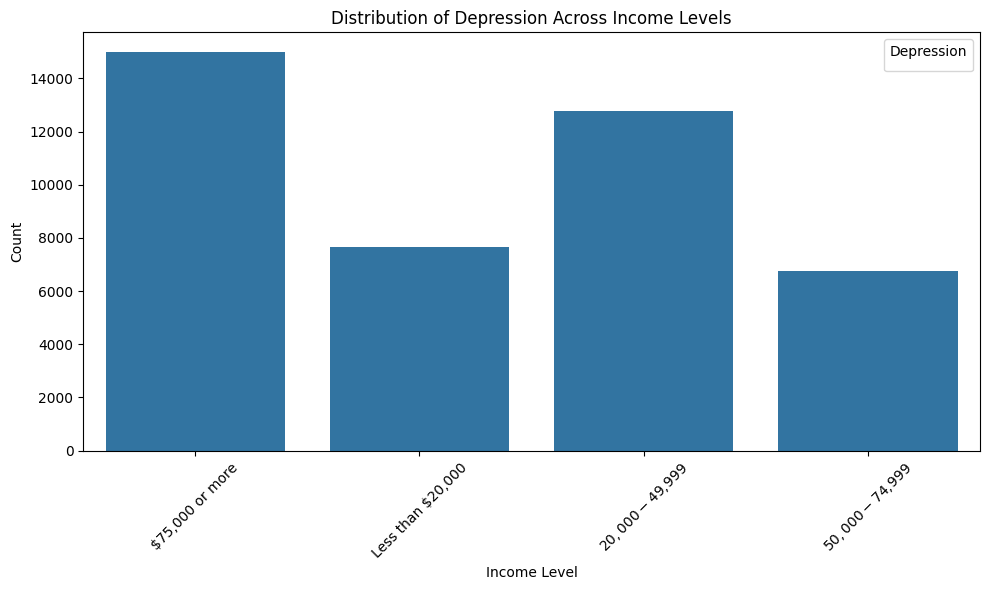

In [64]:
# Distribution of mental health disorders across income levels
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df_cleaned, x='income')
plt.title('Distribution of Depression Across Income Levels')
plt.xlabel('Income Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Depression')
plt.tight_layout()
plt.show()



C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\2975930783.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Depression')


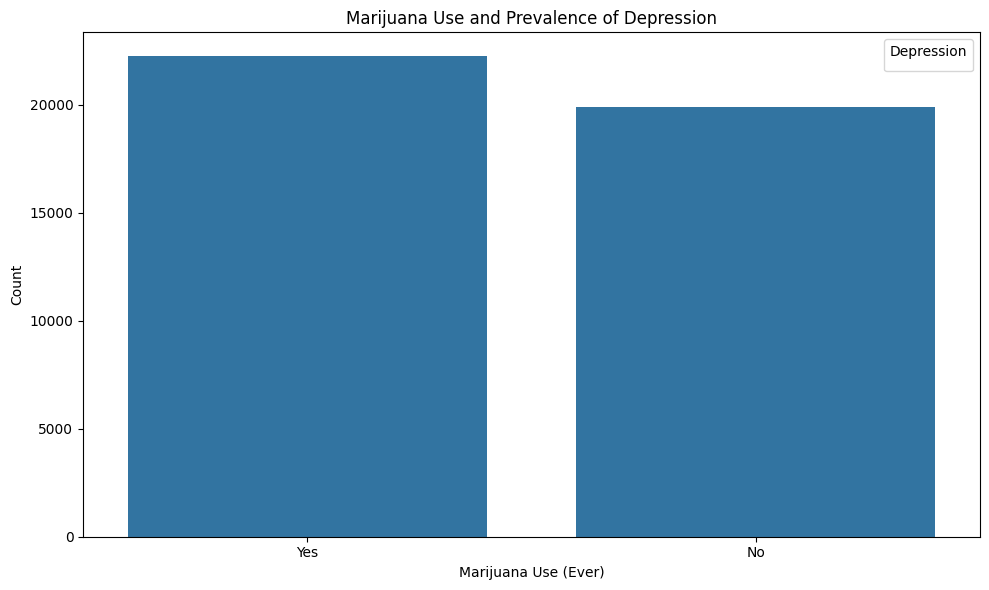

In [65]:
# Relationship between marijuana use and depression
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df_cleaned, x='Ever used marijuana')
plt.title('Marijuana Use and Prevalence of Depression')
plt.xlabel('Marijuana Use (Ever)')
plt.ylabel('Count')
plt.legend(title='Depression')
plt.tight_layout()
plt.show()



C:\Users\Rama Rao\AppData\Local\Temp\ipykernel_5340\3771622830.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Depression')


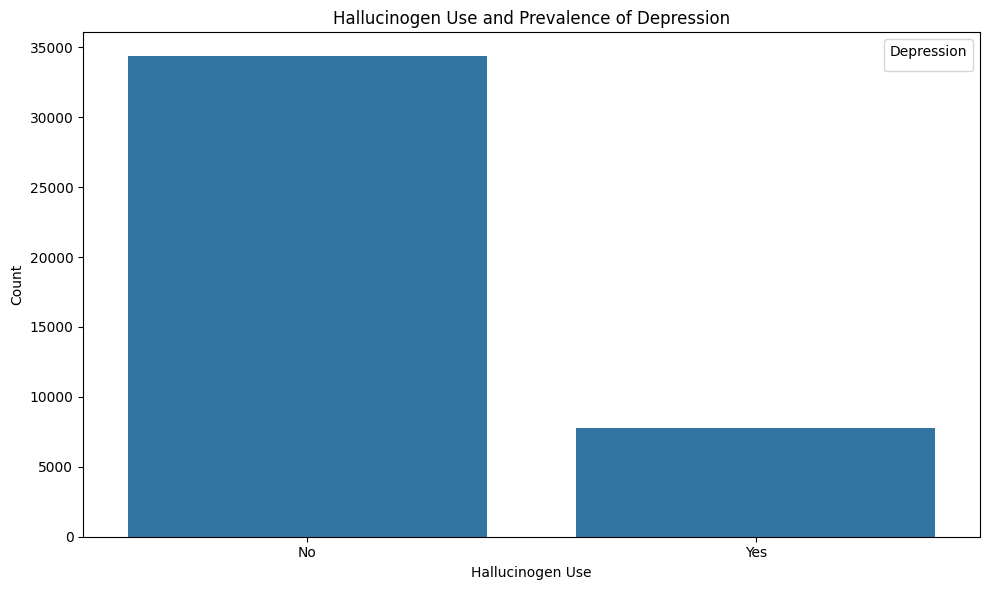

In [68]:
 #Relationship between hallucinogen use and anxiety/depression
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df_cleaned, x='hallucinogens')
plt.title('Hallucinogen Use and Prevalence of Depression')
plt.xlabel('Hallucinogen Use')
plt.ylabel('Count')
plt.legend(title='Depression')
plt.tight_layout()
plt.show()


### From the data we cannot derive a direct relation between income and mental health issues. However, we can see that high use of hallucinogens might
### be related to depression also marijuana use is correlated with depression